# Chapter #3: Statistical Experiments and Significance Testing

Based on Practical Statistics for Data Scientists

Existe uma pipeline para a clássifca inferência estatística:
1. Levantamento de Hipóteses
2. Design do experimento
3. Coletagem de dados
4. Inferências ou conclusões

In [73]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import random

### A/B TEST

É um experimento com dois grupos que recebem tratamentos diferentes. No ramo empresarial é muito utilizado em marketing ou web design, exemplos:
- Teste de dois preços para determinar qual gera mais lucro.
- Teste de dois títulos para uma página web a fim de determinar qual produz mais clicks.
- Teste de dois ads para determinar qual gera mais conversão.

Os indivíduos que participarão do teste A/B são atribuídos ao grupo A ou B aleatoriamente.
Qualquer diferença entre os grupos é motivada por uma das duas coisas:
- Pura chance.
- Efeito distinto de cada tratamento.

Deve-se estabelecer também a métrica de teste que usaremos para comparar os dois grupos. 

Podemos utilizar uma variável binária:

In [33]:
pd.DataFrame({
    "Conversion": [True, False],
    "Ad 1": [200, 23539],
    "Ad 2": [182, 22406]
})

,Conversion,Ad 1,Ad 2
0,True,200,182
1,False,23539,22406


Ou variáveis contínuas:

In [6]:
pd.DataFrame({
    "": ["Média de venda por página"],
    "Preço A": [3.87],
    "Preço B": [4.11]
})

,,Preço A,Preço B
0,Média de venda por página,3.87,4.11


### HYPOTHESIS TESTS (SIGNIFICANCE TESTS)

Propósito de ajudar voce a aprender se a chance aleatória foi responsável pelo efeito observado. Nós tendemos a subestimar a manifestação dos black swans

#### KEY TERMS FOR HYPOTHESIS TESTS
- **Null Hypothesis**: A hipótese em que a chance é a culpada
- **Alternative Hypothesis**: Contra-ponto da hipótese nula

#### The Null Hypothesis $H_0$
É a construção lógica que incorpora a noção de que nada especial aconteceu, e qualquer efeito observado é devido à chance.
- Envolve a premissa de que os tratamentos são equivalentes e qualquer diferença é devido à chance.
- Em relação a fórmulas matemáticas, normalmente está associada aos sinais de $=$, $\ge$, $\le$

#### The Alternative Hypothesis $H_1$
- A natureza da hipótese nula determina a hipótese alternativa, pois deve ser o contra-ponto da hipótese nula.
- Em relação a fórmulas matemáticas, normalmente está associada aos sinais de $\ne$, $\gt$, $\lt$

### RESAMPLING

- Usado para analisar a variabilidade aleatória em estatística
- Usado para melhorar a acurácia de algum modelo de ML

Existem dois tipos principais de procedimentos de reamostragem: bootstrap e testes de permutação. O bootstrap nos ajuda com intervalos de confiança e os testes de permutação nos ajudam com testes de hipóteses.

#### Permutation Test
Permutar significa mudar a ordem de um conjunto de valores. No teste de hipótese, o primeiro passo é a combinação dos resultados dos grupos A e B. Essa é a incorporação da hipótese nula que diz que qualquer diferença é devido à chance. 
1. Combine os resultados dos diferentes grupos em um único data set.
2. Embaralhe os dados combinados e retire aleatoriamente (sem substituição) uma amostra do mesmo tamanho do grupo A.
3. Os dados restantes pertencerão ao grupo B*
4. Calcule a estatística escolhida e anote.
5. Os passos anteriores constituem uma única iteração da permutação, então repita os passos anteriores R vezes para produzir a distribuição da permutação da estatística escolhida.

Agora volte à diferença observada antes da permutação e compare com a distribuição criada acima. Se a diferença observada estiver no meio da distribuição, falhamos em rejeitar a hipótese nula, portanto a diferença não é significativa estatisticamente.

**EXEMPLO**: Uma empresa vendendo serviços de alto-valor quer testar qual design da página faz um trabalho melhor em termos de vendas.

**Observações**:
1. Serviço de alto-valor, portanto, poucos "eventos de sucesso"
2. Google Analytics não mede o tempo de sessão da última sessão que alguém visita. Ao invés de deletar esses dados, Google .Analytics grava como um 0.

$\large{H_0: \mu_{pageA} - \mu_{pageB} \ge 0}$ 


$\large{H_1: \mu_{pageA} - \mu_{pageB} \lt 0}$ 

In [83]:
np.random.seed(10)

hvs = pd.concat([
    pd.DataFrame({"Page": ["A"]*21, "Time": stats.norm.rvs(3.5, 0.8, size=21)}),
    pd.DataFrame({"Page": ["B"]*15, "Time": stats.norm.rvs(3.5, 1, size=15) + .1}),
])

hvs.sample(5)

,Page,Time
11,B,3.732708
6,B,4.997996
3,A,3.493293
12,B,3.123858
19,A,2.636156


In [84]:
mean_A = hvs.query("Page == 'A'").Time.mean()
mean_B = hvs.query("Page == 'B'").Time.mean()

diff_obs = mean_A - mean_B
diff_obs

-0.47732288632473363

In [79]:
def permutation_function(df, nA, nB, col):
    n = nA + nB
    idx_A = set(random.sample(range(n), nA))
    idx_B = set(range(n)) - idx_A
    return df.loc[idx_A, col].mean() - df.loc[idx_B, col].mean()

In [81]:
perm_diff = [permutation_function(hvs, 21, 15, "Time") for _ in range(1000)]

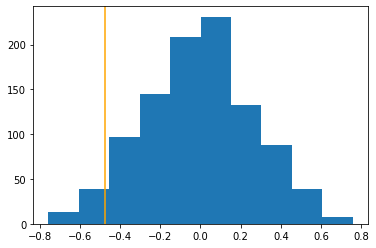

In [82]:
plt.hist(perm_diff)
plt.axvline(diff_obs, color="orange")

In [88]:
p_value = np.mean(np.array(perm_diff) < diff_obs)

p_value
alpha = 0.05 ou 0.01

0.043

In [90]:
import os
os.getcwd().replace("\\", "/")

'C:/Users/itolivei/Documents/sun_learning/notebooks/content'

In [72]:
df = pd.DataFrame({
    "group": ["A"] * 23739 + ["B"] * 22588,
    "conversion": [1] * 200 + [0] * 23539 + [1] * 182 + [0] * 22406
})

print(df.group.value_counts())
print(df.groupby("group").conversion.value_counts())

df.sample(5)

A    23739
B    22588
Name: group, dtype: int64
group  conversion
A      0             23539
       1               200
B      0             22406
       1               182
Name: conversion, dtype: int64


,group,conversion
36349,B,0
21153,A,0
5614,A,0
20823,A,0
16270,A,0


In [67]:
prop_a = df[df["group"] == "A"].conversion.mean()
prop_b = df[df["group"] == "B"].conversion.mean()

real_diff = prop_a - prop_b

In [64]:
perm_diffs = [permutation_function(df, 23739, 22588) for _ in range(1_000)]

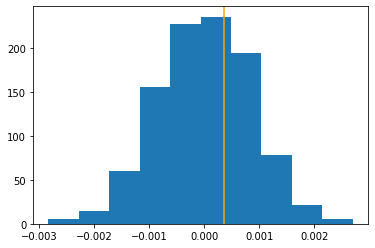

In [68]:
plt.hist(perm_diffs)
plt.axvline(real_diff, color="orange");

In [71]:
np.mean(np.array(perm_diffs) > np.array(real_diff)).mean()

0.324

Voltar à pergunta de o que os data scientists estão preocupados